In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import matplotlib.pyplot as plt


Using TensorFlow backend.


## Load data and preprocessing

In [33]:
def readTrain():
    all_df = pd.read_csv("all_info_utf8.csv")
    grouped_df = all_df.groupby(all_df.作物名稱)
    banana = grouped_df.get_group('香蕉')
    market_df = banana.groupby(banana.市場名稱)
    market = market_df.get_group('台北一')
    market = market.drop(columns=['作物代號', '作物名稱', '市場代號', '市場名稱','3_day_return', '1_day_return', '5_day_return', 'DateTime'])
    market = market.rename(columns = {'平均價': 'Price', '交易量': 'Trading_volume','強度':'Typhoon_strength','警報發布報數':'Warning_freq'}, inplace = False)
    #market = market.rename(columns = {'交易量': 'Trading_volume','強度':'Typhoon_strength','警報發布報數':'Warning_freq'}, inplace = False)
    return market

In [34]:
# Normalize all attribute
def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm

In [35]:
# Denormalize test and predict value
def de_normalize(test,y_max,y_min,y_mean):
    test_denorm = test.apply(lambda y: y * (y_max - y_min) + y_mean)
    return test_denorm

In [36]:
# Build training set
def buildTrain(train, pastDay=30, futureDay=5):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["Price"]))
    return np.array(X_train), np.array(Y_train)

In [37]:
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

In [38]:
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val


In [39]:
dataset =  readTrain()

In [40]:
dataset

,Year,Month,Day,Price,Trading_volume,Typhoon_strength,Warning_freq,C0A530_StnPres,C0A530_Temperature,C0A530_WS,...,C0Z061_StnPres,C0Z061_Temperature,C0Z061_WS,C0Z061_WSGust,C0Z061_Precp,467660_StnPres,467660_Temperature,467660_WS,467660_WSGust,467660_Precp
12024,2012.0,1.0,1.0,18.2,21521.0,0.0,0.0,988.0,11.5,1.4,...,1004.9,14.7,0.6,5.6,2.0,1019.6,18.4,1.6,9.4,0.0
12025,2012.0,1.0,3.0,18.4,14700.0,0.0,0.0,985.7,12.5,2.1,...,1002.6,16.9,0.6,7.7,0.0,1017.9,19.5,1.6,6.6,0.0
12026,2012.0,1.0,4.0,18.9,19953.0,0.0,0.0,990.9,7.3,1.6,...,1007.2,13.0,1.4,7.8,0.5,1021.8,17.1,2.5,13.2,0.0
12027,2012.0,1.0,5.0,18.8,18523.0,0.0,0.0,988.5,9.3,1.2,...,1006.7,12.5,0.4,4.4,0.5,1021.6,15.2,1.5,6.7,0.4
12028,2012.0,1.0,6.0,19.5,22340.0,0.0,0.0,987.0,13.1,0.7,...,1004.0,15.5,0.4,4.4,2.0,1019.2,18.4,1.3,6.3,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14429,2019.0,12.0,26.0,34.0,21945.0,0.0,0.0,983.6,16.7,1.2,...,999.6,20.8,0.7,7.6,0.0,1013.9,23.2,2.7,14.4,0.0
14430,2019.0,12.0,27.0,33.2,15308.0,0.0,0.0,988.5,11.9,2.0,...,1005.5,15.7,1.0,5.5,0.5,1019.2,19.3,2.8,15.1,0.0
14431,2019.0,12.0,28.0,32.6,17840.0,0.0,0.0,986.9,15.9,2.2,...,1005.9,17.1,0.5,4.5,0.0,1020.1,19.8,2.1,10.3,0.8
14432,2019.0,12.0,29.0,32.2,13077.0,0.0,0.0,984.9,18.4,1.1,...,1004.3,17.8,0.4,3.6,69.5,1018.4,19.4,1.4,8.2,66.0


In [69]:
dataset[:2111].tail(10)

,Year,Month,Day,Price,Trading_volume,Typhoon_strength,Warning_freq,C0A530_StnPres,C0A530_Temperature,C0A530_WS,...,C0Z061_StnPres,C0Z061_Temperature,C0Z061_WS,C0Z061_WSGust,C0Z061_Precp,467660_StnPres,467660_Temperature,467660_WS,467660_WSGust,467660_Precp
14125,2018.0,12.0,20.0,32.3,20633.0,0.0,0.0,983.4,16.3,0.8,...,1001.6,17.9,0.7,3.8,0.0,1016.5,21.3,1.2,6.2,0.0
14126,2018.0,12.0,21.0,32.2,24505.0,0.0,0.0,983.5,19.0,1.3,...,1001.4,19.5,0.5,4.0,0.0,1016.2,22.8,1.5,8.5,0.0
14127,2018.0,12.0,22.0,29.9,21768.0,0.0,0.0,983.3,21.1,0.9,...,1001.5,20.2,0.4,3.0,1.5,1016.1,23.8,1.4,6.6,0.0
14128,2018.0,12.0,23.0,28.2,19338.0,0.0,0.0,985.3,18.0,1.8,...,1001.9,20.3,0.7,5.9,15.0,1016.1,22.5,1.4,8.7,41.1
14129,2018.0,12.0,25.0,27.5,20056.0,0.0,0.0,981.4,19.3,1.2,...,999.2,19.9,0.2,2.8,0.5,1013.3,22.1,1.5,6.6,0.7
14130,2018.0,12.0,26.0,26.6,19066.0,0.0,0.0,980.1,18.3,0.5,...,996.1,21.5,0.5,4.0,4.5,1010.8,23.7,1.9,9.8,0.0
14131,2018.0,12.0,27.0,27.1,15444.0,0.0,0.0,984.7,14.8,1.3,...,1000.5,18.4,0.6,4.8,1.0,1014.4,21.9,2.2,12.9,0.0
14132,2018.0,12.0,28.0,27.2,14306.0,0.0,0.0,990.7,11.8,2.5,...,1006.8,16.7,1.3,7.2,0.0,1020.4,20.1,2.5,13.7,0.0
14133,2018.0,12.0,29.0,27.8,16381.0,0.0,0.0,994.2,10.5,2.6,...,1010.7,15.2,1.3,8.0,0.0,1024.9,17.9,2.6,16.8,0.0
14134,2018.0,12.0,30.0,26.9,16236.0,0.0,0.0,992.5,12.6,2.5,...,1010.0,16.6,1.2,7.1,0.0,1024.3,19.0,2.5,14.3,0.0


## many to one model

In [41]:
def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
    # output shape: (1, 1)
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

### Training (2012~2018): past 7 day to predict next 1 day

In [58]:
train = dataset[:2111]

train_norm = normalize(train)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 7, 1)
X_train, Y_train = shuffle(X_train, Y_train)
# because no return sequence, Y_train and Y_val shape must be 2 dimension
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

loss = history.history['loss']
epochs = range(len(loss))

c:\users\user\anaconda3\envs\lstm-shap\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\user\anaconda3\envs\lstm-shap\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, input_shape=(7, 82))`
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                3720      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 3,731
Trainable params: 3,731
Non-trainable params: 0
_________________________________________________________________
Train on 1893 samples, validate on 210 samples
Epoch 1/1000
1893/1893 [==============================] - 1s 331us/step - loss: 0.0254 - val_loss: 0.0169
Epoch 2/1000
1893/1893 [==============================] - 0s 96us/step - loss: 0.0167 - val_loss: 0.0112
Epoch 3/1000
1893/1893 [==============================] - 0s 101us/step - loss: 0.0112 - val_loss: 0.0079
Epoch 4/1000
1893/1893 [==============================] - 0s 97us/step - loss: 0.0073 - val_loss: 0.0052
Epoch 5/1000
1893/1893 [=====================

1893/1893 [==============================] - 0s 105us/step - loss: 7.8340e-04 - val_loss: 8.8835e-04
Epoch 70/1000
1893/1893 [==============================] - 0s 112us/step - loss: 7.5901e-04 - val_loss: 8.8242e-04
Epoch 71/1000
1893/1893 [==============================] - 0s 112us/step - loss: 7.6256e-04 - val_loss: 8.5559e-04
Epoch 72/1000
1893/1893 [==============================] - 0s 100us/step - loss: 7.4687e-04 - val_loss: 9.1301e-04
Epoch 73/1000
1893/1893 [==============================] - 0s 98us/step - loss: 7.5150e-04 - val_loss: 8.5720e-04
Epoch 74/1000
1893/1893 [==============================] - 0s 96us/step - loss: 7.4324e-04 - val_loss: 8.4313e-04
Epoch 75/1000
1893/1893 [==============================] - 0s 118us/step - loss: 7.3718e-04 - val_loss: 8.4418e-04
Epoch 76/1000
1893/1893 [==============================] - 0s 102us/step - loss: 7.3909e-04 - val_loss: 8.3356e-04
Epoch 77/1000
1893/1893 [==============================] - 0s 96us/step - loss: 7.2891e-04 - val

1893/1893 [==============================] - 0s 112us/step - loss: 5.2216e-04 - val_loss: 6.7006e-04
Epoch 141/1000
1893/1893 [==============================] - 0s 103us/step - loss: 5.1436e-04 - val_loss: 7.0825e-04
Epoch 142/1000
1893/1893 [==============================] - 0s 102us/step - loss: 5.2252e-04 - val_loss: 7.3410e-04
Epoch 143/1000
1893/1893 [==============================] - 0s 96us/step - loss: 5.0254e-04 - val_loss: 6.7454e-04
Epoch 144/1000
1893/1893 [==============================] - 0s 100us/step - loss: 5.0762e-04 - val_loss: 6.4999e-04
Epoch 145/1000
1893/1893 [==============================] - 0s 106us/step - loss: 4.9419e-04 - val_loss: 6.5521e-04
Epoch 146/1000
1893/1893 [==============================] - 0s 95us/step - loss: 4.9690e-04 - val_loss: 6.5682e-04
Epoch 147/1000
1893/1893 [==============================] - 0s 103us/step - loss: 4.8661e-04 - val_loss: 6.9126e-04
Epoch 148/1000
1893/1893 [==============================] - 0s 117us/step - loss: 5.0050e

1893/1893 [==============================] - 0s 98us/step - loss: 3.8232e-04 - val_loss: 6.0314e-04
Epoch 212/1000
1893/1893 [==============================] - 0s 97us/step - loss: 3.8704e-04 - val_loss: 6.0891e-04
Epoch 213/1000
1893/1893 [==============================] - 0s 95us/step - loss: 3.8094e-04 - val_loss: 5.9425e-04
Epoch 214/1000
1893/1893 [==============================] - 0s 95us/step - loss: 3.7636e-04 - val_loss: 5.8139e-04
Epoch 215/1000
1893/1893 [==============================] - 0s 95us/step - loss: 3.8010e-04 - val_loss: 6.2239e-04
Epoch 216/1000
1893/1893 [==============================] - 0s 98us/step - loss: 3.8578e-04 - val_loss: 5.8409e-04
Epoch 217/1000
1893/1893 [==============================] - 0s 103us/step - loss: 3.7721e-04 - val_loss: 5.7990e-04
Epoch 218/1000
1893/1893 [==============================] - 0s 101us/step - loss: 3.7580e-04 - val_loss: 5.7760e-04
Epoch 219/1000
1893/1893 [==============================] - 0s 100us/step - loss: 3.8007e-04 

1893/1893 [==============================] - 0s 102us/step - loss: 3.2162e-04 - val_loss: 5.8194e-04
Epoch 283/1000
1893/1893 [==============================] - 0s 103us/step - loss: 3.2407e-04 - val_loss: 5.8270e-04
Epoch 284/1000
1893/1893 [==============================] - 0s 98us/step - loss: 3.3392e-04 - val_loss: 5.8657e-04
Epoch 285/1000
1893/1893 [==============================] - 0s 107us/step - loss: 3.2435e-04 - val_loss: 5.7024e-04
Epoch 286/1000
1893/1893 [==============================] - 0s 104us/step - loss: 3.1217e-04 - val_loss: 5.5187e-04
Epoch 287/1000
1893/1893 [==============================] - 0s 96us/step - loss: 3.1103e-04 - val_loss: 5.8828e-04
Epoch 288/1000
1893/1893 [==============================] - 0s 129us/step - loss: 3.1634e-04 - val_loss: 5.5184e-04
Epoch 289/1000
1893/1893 [==============================] - 0s 111us/step - loss: 3.1529e-04 - val_loss: 5.7945e-04
Epoch 290/1000
1893/1893 [==============================] - 0s 95us/step - loss: 3.0969e-

In [68]:
X_train.shape

(1893, 7, 82)

In [66]:
Y_train.shape

(1893, 1)

### Testing (2019)

In [44]:
test = dataset[2104:]

In [70]:
test.tail(10)

,Year,Month,Day,Price,Trading_volume,Typhoon_strength,Warning_freq,C0A530_StnPres,C0A530_Temperature,C0A530_WS,...,C0Z061_StnPres,C0Z061_Temperature,C0Z061_WS,C0Z061_WSGust,C0Z061_Precp,467660_StnPres,467660_Temperature,467660_WS,467660_WSGust,467660_Precp
14424,2019.0,12.0,20.0,31.9,12611.0,0.0,0.0,986.8,16.1,1.2,...,1004.0,18.5,0.7,4.0,5.0,1018.1,21.9,1.8,10.2,0.5
14425,2019.0,12.0,21.0,32.0,16661.0,0.0,0.0,983.2,18.4,0.2,...,1000.4,20.2,0.3,4.4,0.0,1015.2,23.1,1.1,5.1,0.2
14426,2019.0,12.0,22.0,32.6,11414.0,0.0,0.0,981.7,17.6,0.9,...,998.3,22.0,0.5,4.2,2.5,1013.1,23.4,1.9,10.3,0.0
14427,2019.0,12.0,24.0,35.3,18697.0,0.0,0.0,984.4,17.2,0.8,...,1001.5,20.2,0.5,3.7,0.0,1016.1,22.6,1.6,6.4,0.0
14428,2019.0,12.0,25.0,34.8,18119.0,0.0,0.0,982.4,18.7,1.1,...,1000.7,19.8,0.4,3.6,0.0,1015.2,22.8,1.4,7.1,0.0
14429,2019.0,12.0,26.0,34.0,21945.0,0.0,0.0,983.6,16.7,1.2,...,999.6,20.8,0.7,7.6,0.0,1013.9,23.2,2.7,14.4,0.0
14430,2019.0,12.0,27.0,33.2,15308.0,0.0,0.0,988.5,11.9,2.0,...,1005.5,15.7,1.0,5.5,0.5,1019.2,19.3,2.8,15.1,0.0
14431,2019.0,12.0,28.0,32.6,17840.0,0.0,0.0,986.9,15.9,2.2,...,1005.9,17.1,0.5,4.5,0.0,1020.1,19.8,2.1,10.3,0.8
14432,2019.0,12.0,29.0,32.2,13077.0,0.0,0.0,984.9,18.4,1.1,...,1004.3,17.8,0.4,3.6,69.5,1018.4,19.4,1.4,8.2,66.0
14433,2019.0,12.0,31.0,32.2,16827.0,0.0,0.0,993.8,12.8,2.1,...,1010.5,17.1,1.0,6.1,4.0,1024.3,20.1,3.0,16.2,0.0


In [46]:
# Remember max min mean in order to do denormalize
y_max = np.max(test['Price'])
y_min = np.min(test['Price'])
y_mean = np.mean(test['Price'])

In [47]:
test_norm = normalize(test)

In [48]:
X_test, y_test = buildTrain(test_norm, 7, 1)

In [49]:
# Predict the model
y_pred = model.predict(X_test)

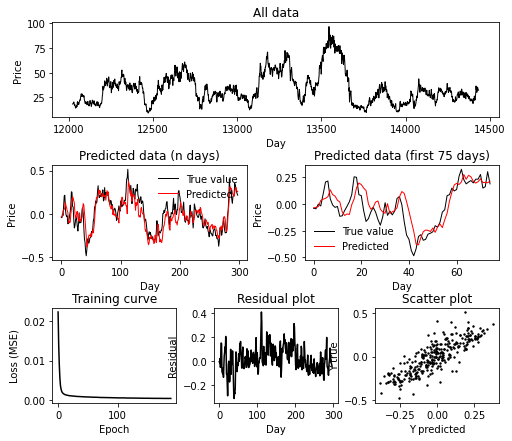

mse=0.011
r2=0.691


In [50]:
# plot the result

plt.figure(figsize=(8,7))

plt.subplot(3, 1, 1)
plt.plot(dataset['Price'], color='black', linewidth=1, label='True value')
plt.ylabel("Price")
plt.xlabel("Day")
plt.title("All data")

plt.subplot(3, 2, 3)
plt.plot(y_test, color='black', linewidth=1, label='True value')
plt.plot(y_pred, color='red', linewidth=1, label='Predicted')
plt.legend(frameon=False)
plt.ylabel("Price")
plt.xlabel("Day")
plt.title("Predicted data (n days)")

# 畫出前 75 天的預測
plt.subplot(3, 2, 4)
plt.plot(y_test[0:75], color='black', linewidth=1, label='True value')
plt.plot(y_pred[0:75], color='red', linewidth=1, label='Predicted')
plt.legend(frameon=False)
plt.ylabel("Price")
plt.xlabel("Day")
plt.title("Predicted data (first 75 days)")

# 訓練曲線，殘插圖，散點圖
plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='black')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 3, 8)
plt.plot(y_test - y_pred, color='black')
plt.ylabel("Residual")
plt.xlabel("Day")
plt.title("Residual plot")

plt.subplot(3, 3, 9)
plt.scatter(y_pred, y_test, s=2, color='black')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("mse=" + str(round(mse,3)))
print("r2=" + str(round(r2,3)))

In [51]:
# Denormalize the truth value
y_test_df = pd.DataFrame(y_test)
y_test_denorm = de_normalize(y_test_df,y_max,y_min,y_mean)

In [52]:
# Denormalize the predict value
y_pred_df = pd.DataFrame(y_pred)
y_pred_denorm = de_normalize(y_pred_df,y_max,y_min,y_mean)

In [22]:
y_test_denorm.head()

,0
0,-2.941176
1,-5.395683
2,1.486989
3,1.893939
4,11.787072


In [23]:
y_pred_denorm.head()

,0
0,12.697749
1,13.501663
2,-5.432840
3,3.562510
4,18.644051


In [31]:
mean_squared_error(y_test, y_pred)

0.048085102440569245

In [24]:
output = pd.concat([y_test_denorm,y_pred_denorm],axis=1)
output.columns = ['3_day_return','3_day_return_pred']

In [25]:
Date = dataset[-299:-1][["Year","Month","Day"]].reset_index()
Date = Date.astype({"Year": int, "Month": int, "Day": int})

In [26]:
output['date'] = Date[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1)
output['date'] = pd.to_datetime(output['date'])
output = output[['date','3_day_return','3_day_return_pred']]

In [27]:
output

,date,3_day_return,3_day_return_pred
0,2019-01-01,-2.941176,12.697749
1,2019-01-02,-5.395683,13.501663
2,2019-01-03,1.486989,-5.432840
3,2019-01-04,1.893939,3.562510
4,2019-01-05,11.787072,18.644051
...,...,...,...
293,2019-12-25,8.750000,7.686278
294,2019-12-26,4.294479,2.715242
295,2019-12-27,-5.949008,-11.322243
296,2019-12-28,-6.321839,-4.027544


In [330]:
output.to_csv('./Outputs/2019_台北一_香蕉_3_day_return.csv', index=False)

In [331]:
for weight in model.get_weights(): # weights from Dense layer omitted
    print(weight.shape)

(82, 40)
(10, 40)
(40,)
(10, 1)
(1,)


In [332]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, X_train)

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test)

In [333]:
# init the JS visualization code
shap.initjs()

shap.force_plot(explainer.expected_value[0], shap_values[0][:,0,:], test)
#shap.summary_plot(explainer.expected_value[0], shap_values[0][0],feature_names=train,max_display=10,plot_type='bar')

In [334]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:,0,:][0,:], test.iloc[0,:]) # input Day1 effect

In [335]:
shap_values[0][:,0,:].shape

(298, 82)

In [336]:
test[8:].shape

(298, 82)

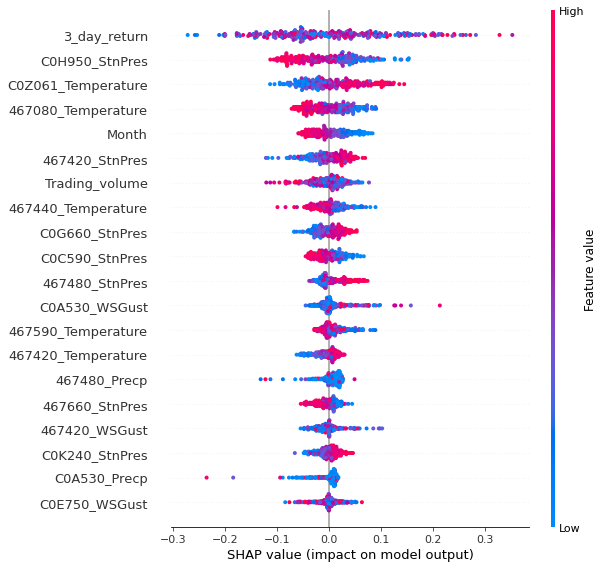

In [343]:
# summarize the effects of all the features
shap.summary_plot(shap_values[0][:,6,:], test[8:]) # input Day1 effect

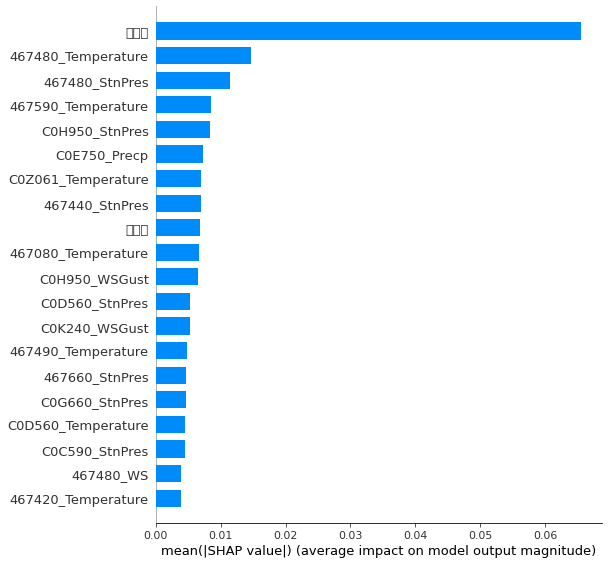

In [244]:
shap.summary_plot(shap_values[0][:,6,:], test[8:], plot_type="bar")